### Auto Encoder Training Modelling.

This is an Auto Encoder Training Routine Test


In [39]:
import os
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
import ast 
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# import torch
import torch
import torch.nn as nn

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
img_dir = 'images_png'
data = pd.read_csv('data_info_file.csv')

In [9]:
class MammoDataset(Dataset):

    def __init__(self, img_dir, data, transform=None, train=True ):
        self.img_dir = img_dir
        self.transform = transform
        self.data = data
        
        if train:
            self.data = self.data[self.data['split'] == 'training']
        else:
            self.data = self.data[self.data['split'] == 'test']


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join( self.img_dir, self.data.iloc[index, 0], self.data.iloc[index, 2] + '.png' )
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        
        return img 

In [10]:
# transform=transforms.Compose([ transforms.Resize(512), transforms.ToTensor()])
train_data = MammoDataset(img_dir, data, transform=transforms.Compose([ transforms.ToTensor()]) )  
test_data = MammoDataset(img_dir, data, transform=transforms.Compose([ transforms.ToTensor()]), train=False) 

In [37]:
import torch
import torch.nn as nn
from torch import optim

In [35]:
class Encoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()
        
        # Convolutional layers
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),   # Output: 760 x 456
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: 380 x 228
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 190 x 114
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: 95 x 57
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# Output: 48 x 29
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),# Output: 24 x 15
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),# Output: 12 x 8
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),# Output: 6 x 4
            nn.BatchNorm2d(2048),
            nn.ReLU(True)
        )
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        # Linear layers
        self.encoder_lin = nn.Sequential(
            nn.Linear(2048 * 6 * 4, 512),
            nn.ReLU(True),
            nn.Linear(512, encoded_dim)
        )
    
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    

class Decoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()

        # Linear layers
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 2048 * 6 * 4),
            nn.ReLU(True)
        )

        # Unflatten layer
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(2048, 6, 4))

        # Convolutional layers with correct output dimensions
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 12 x 8
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # Output: 24 x 16
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: 48 x 32
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: 96 x 64
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Output: 192 x 128
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # Output: 384 x 256
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # Output: 768 x 512
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=(0, 1), output_padding=(0, 0)),  # Output: 1520 x 1025
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        # Crop to match original dimensions (1520 x 912)
        x = x[:, :, :1520, :912]
        return x

In [36]:
def test_encoder_decoder():
    # Create a dummy input image of size (batch_size, channels, height, width)
    x = torch.randn(1, 1, 1520, 912)
    
    # Instantiate the encoder and decoder
    encoded_dim = 64
    encoder = Encoder(encoded_dim)
    decoder = Decoder(encoded_dim)
    
    # Pass the input through the encoder
    encoded = encoder(x)
    print(f"Encoded shape: {encoded.shape}")  # Should be (1, encoded_dim)
    
    # Pass the encoded vector through the decoder
    decoded = decoder(encoded)
    print(f"Decoded shape: {decoded.shape}")  # Should be (1, 1, 1520, 912)
    
    # Check if the decoded output matches the input size
    #assert decoded.shape == x.shape, "Decoded output size does not match input size."
    #print("Test passed: Decoded output size matches input size.")

# Run the test
test_encoder_decoder()

Encoded shape: torch.Size([1, 64])
Decoded shape: torch.Size([1, 1, 1520, 912])


In [69]:
# Choose encoded dimension
encoded_dim = 64

# train and test data loaders
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Instantiate the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
encoder = Encoder(encoded_dim).to(device)
decoder = Decoder(encoded_dim).to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
params_to_optimize = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-4)


In [70]:
num_epochs = 20
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    running_loss = 0.0
    
    for images in train_loader:
        images = images.to(device)
        
        # Forward pass
        encoded = encoder(images)
        decoded = decoder(encoded)
        
        # Compute loss
        loss = criterion(decoded, images)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")
    
    # Validation
    encoder.eval()
    decoder.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            encoded = encoder(images)
            decoded = decoder(encoded)
            loss = criterion(decoded, images)
            test_loss += loss.item() * images.size(0)
    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Testing Loss: {epoch_test_loss:.4f}")

Epoch [1/20], Training Loss: 0.0146
Epoch [1/20], Testing Loss: 0.0121
Epoch [2/20], Training Loss: 0.0091
Epoch [2/20], Testing Loss: 0.0268
Epoch [3/20], Training Loss: 0.0083
Epoch [3/20], Testing Loss: 0.0344
Epoch [4/20], Training Loss: 0.0070
Epoch [4/20], Testing Loss: 0.0126
Epoch [5/20], Training Loss: 0.0060
Epoch [5/20], Testing Loss: 0.0140
Epoch [6/20], Training Loss: 0.0055
Epoch [6/20], Testing Loss: 0.0054
Epoch [7/20], Training Loss: 0.0053
Epoch [7/20], Testing Loss: 0.0068
Epoch [8/20], Training Loss: 0.0050
Epoch [8/20], Testing Loss: 0.0049
Epoch [9/20], Training Loss: 0.0050
Epoch [9/20], Testing Loss: 0.0053
Epoch [10/20], Training Loss: 0.0048
Epoch [10/20], Testing Loss: 0.0323
Epoch [11/20], Training Loss: 0.0047
Epoch [11/20], Testing Loss: 0.0092
Epoch [12/20], Training Loss: 0.0046
Epoch [12/20], Testing Loss: 0.0043
Epoch [13/20], Training Loss: 0.0046
Epoch [13/20], Testing Loss: 0.0057
Epoch [14/20], Training Loss: 0.0044
Epoch [14/20], Testing Loss: 0.0

In [60]:
torch.save(encoder.state_dict(), f'models/encoder_epoch_{epoch+1}.pth')
torch.save(decoder.state_dict(), f'models/decoder_epoch_{epoch+1}.pth')

### Visualizing the Output

In [61]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# Function to display images
def display_images(original, reconstructed, idx=0):
    """
    Displays the original and reconstructed images side by side.
    
    Parameters:
    - original: Tensor of shape (batch_size, 1, H, W)
    - reconstructed: Tensor of shape (batch_size, 1, H, W)
    - idx: Index of the image in the batch to display
    """
    # Move tensors to CPU and detach
    original_img = original[idx].cpu().detach().numpy().squeeze()
    reconstructed_img = reconstructed[idx].cpu().detach().numpy().squeeze()
    
    # Optionally resize the images for visualization
    # resize_transform = transforms.Compose([
    #     transforms.ToPILImage(),
    #     transforms.Resize((512, 512)),  # Adjust size as needed
    #     transforms.ToTensor()
    # ])
    
    # original_img_resized = resize_transform(torch.from_numpy(original_img).unsqueeze(0)).squeeze().numpy()
    # reconstructed_img_resized = resize_transform(torch.from_numpy(reconstructed_img).unsqueeze(0)).squeeze().numpy()
    
    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(8, 6))
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(reconstructed_img)
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')
    plt.tight_layout()
    #plt.show()
    plt.savefig('epoch_10_input_output.png')

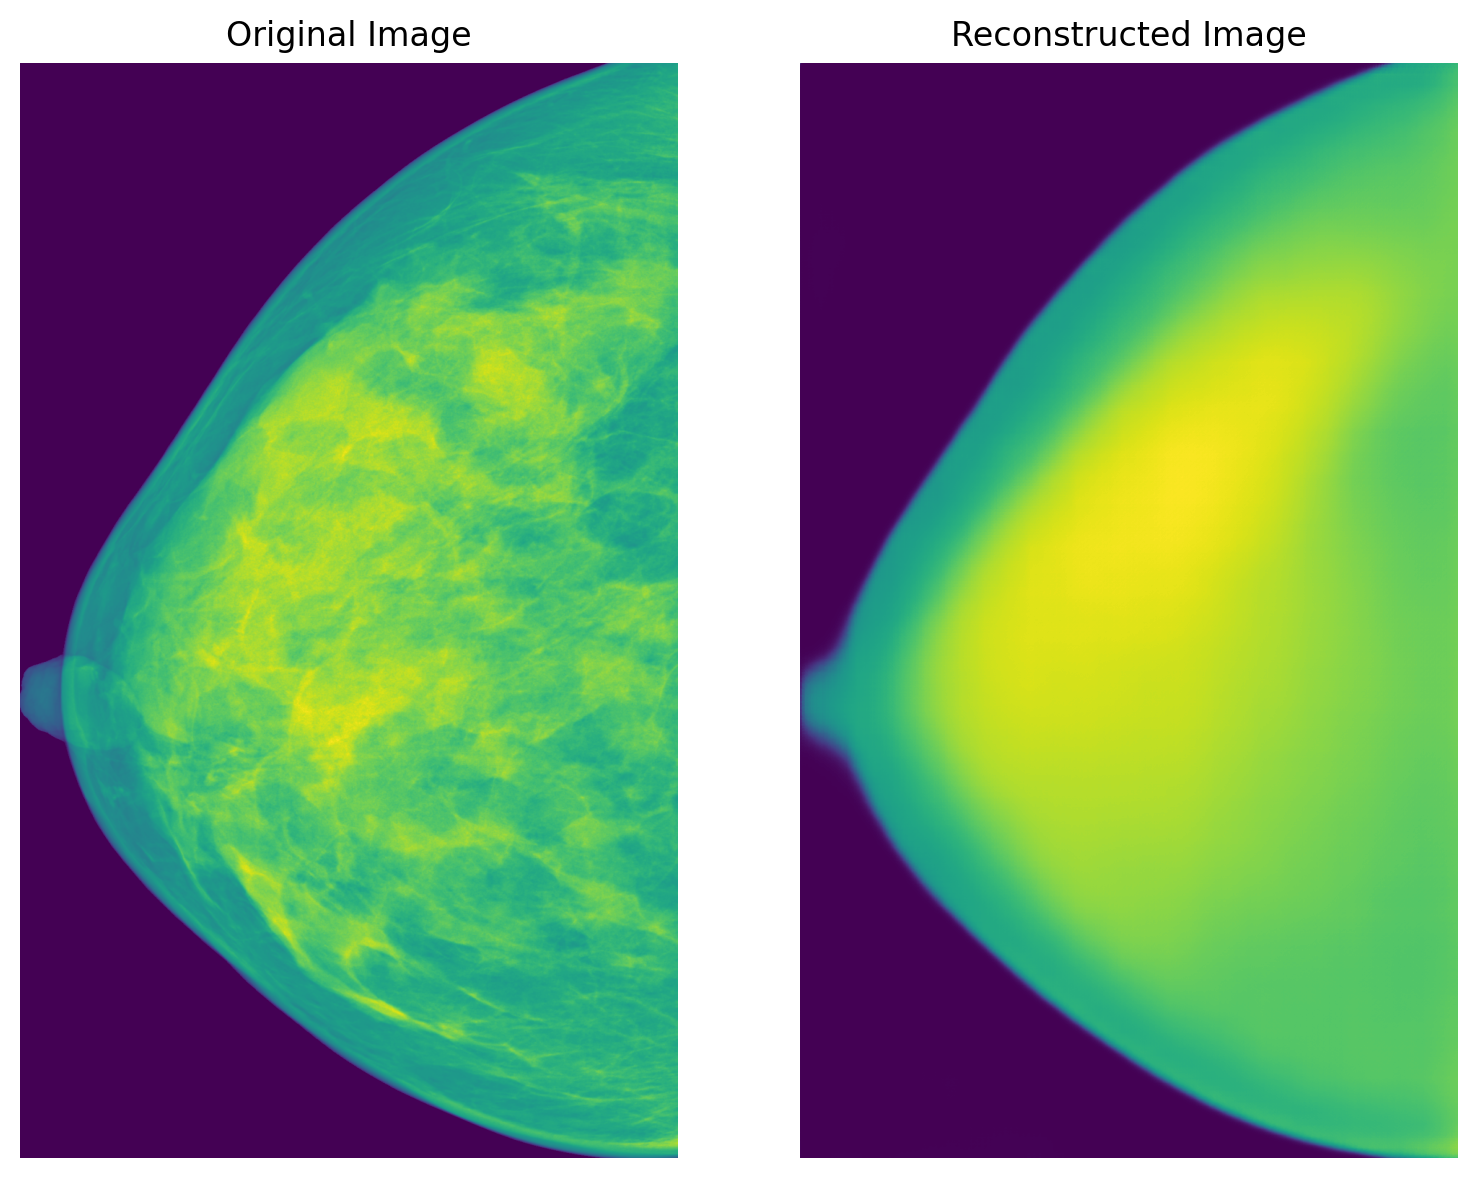

In [68]:
# Set the models to evaluation mode
encoder.eval()
decoder.eval()

# Load a batch of images from the test loader
with torch.no_grad():
    for images in test_loader:
        # Move images to the device
        images = images.to(device)
        
        # Pass images through the autoencoder
        encoded = encoder(images)
        decoded = decoder(encoded)
        
        # Display the first image in the batch
        display_images(images, decoded, idx=1)
        
        # If you want to display more images, remove the break statement
        break